线性回归模型的评估指标：

    连续型的因变量评估 -- RMSE
    离散型的因变量评估 -- 混淆矩阵、ROC曲线、K-S曲线

PR曲线：

    纵轴 -- 查准率P = TP/(TP+FP) = 真正例/(真正例+假正例) = 真正例/(预测正例总数)
    横轴 -- 查全率R = TP/(TP+FN) = 真正例/(真正例+假反例) = 真正例/(实际正例总数)

ROC曲线：

    纵轴 -- 真正例率TPR = TP/(TP+FN) = 真正例/(真正例+假反例) = 真正例/(实际正例总数)
    横轴 -- 假正例率FPR = FP/(TN+FP) = 假正例/(真反例+假正例) = 假正例/(实际反例总数)
    
    ROC曲线下的阴影面积AUC越大越好，一般0.8以上，模型就可以接受了。

K-S曲线：

    纵轴 -- TPR和FPR用作y轴，得到两条曲线
    横轴 -- 模型计算的score值，从大到小排序，取出10%、20%、...90%所对应的分位数
    
    KS值越大越好，KS = TPR-FPR = 真正例率-假正例率,一般大于0.4，模型可以接受

# K-S曲线
1.按照模型计算的score值，从大到小排序

2.取出10%、20%、...90%所对应的分位数，并以此作为分位数的阈值，计算TPR和FPR的值

3.将10%、20%、...90%这样的分位点用作绘图的x轴，将TPR和FPR用作y轴，得到两条曲线。

In [ ]:
# 导入第三方包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%config ZMQInteractiveShell.ast_node_interactivity='all'   # nootbook使用

In [ ]:
virtual_data = pd.read_excel(r'virtual_data.xlsx')
virtual_data.head()
# class为实际的分类

In [ ]:
# 自定义绘制ks曲线的函数
def plot_ks(y_test, y_score, positive_flag):
    
    
    # 对y_test,y_score重新设置索引
    y_test.index = np.arange(len(y_test))
    y_score.index = np.arange(len(y_score))
    
    # 构建目标数据集
    target_data = pd.DataFrame({'y_test':y_test, 'y_score':y_score})
    
    # 按y_score降序排列
    target_data.sort_values(by = 'y_score', ascending = False, inplace = True)
    
    # 自定义分位点
    cuts = np.arange(0.1,1,0.1)  # array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    
    # 计算各分位点对应的Score值
    index = len(target_data.y_score)*cuts 
    scores = target_data.y_score.iloc[index.astype('int')]
    
    # 根据不同的Score值，计算Sensitivity真正例率 和 Specificity真负利率
    Sensitivity = []   # TPR
    Specificity = []   # FPR = 1-Specificity
    
    for score in scores:
        # 真正例率TPR = TP/(TP+FN) = 真正例/(真正例+假反例) = 真正例/(实际正例总数)
        # 正例覆盖样本数量与实际正例样本量
        positive_recall = target_data.loc[(target_data.y_test == positive_flag) 
                                          & (target_data.y_score>score),:].shape[0] # 正例覆盖样本数量
        positive = sum(target_data.y_test == positive_flag)   # 实际正例样本量
        
        # 假正例率FPR = FP/(TN+FP) = 假正例/(真反例+假正例) = 假正例/(实际反例总数)
        # 负例覆盖率specificity = 1 - FPR = 正确预测的负例数/实际负例数
        # 负例覆盖样本数量与实际负例样本量
        negative_recall = target_data.loc[(target_data.y_test != positive_flag) 
                                          & (target_data.y_score<=score),:].shape[0]
        negative = sum(target_data.y_test != positive_flag)  # 实际负例样本量
        
        Sensitivity.append(positive_recall/positive)
        Specificity.append(negative_recall/negative)
        
    # 构建绘图数据
    plot_data = pd.DataFrame({'cuts':cuts,'y1':1-np.array(Specificity),'y2':np.array(Sensitivity), 
                              'ks':np.array(Sensitivity)-(1-np.array(Specificity))})
    print(plot_data)
    
    # 以分位数为x轴，以Sensitivity和1-Specificity分别为y轴，画两条线
    plt.plot([0]+cuts.tolist()+[1], [0]+plot_data.y1.tolist()+[1], label = '1-Specificity')
    plt.plot([0]+cuts.tolist()+[1], [0]+plot_data.y2.tolist()+[1], label = 'Sensitivity')
    
    # 寻找Sensitivity和1-Specificity之差的最大值索引
    max_ks_index = np.argmax(plot_data.ks)
    # 添加参考线
    plt.vlines(plot_data.cuts[max_ks_index],    # 横坐标
               ymin = plot_data.y1[max_ks_index], 
               ymax = plot_data.y2[max_ks_index], 
               linestyles = '--')
#     # 添加文本信息
    plt.text(x = plot_data.cuts[max_ks_index]+0.01,
             y = plot_data.y1[max_ks_index]+plot_data.ks[max_ks_index]/2,
             s = 'KS= %.2f' %plot_data.ks[max_ks_index])
    # 显示图例
    plt.legend()
    # 显示图形
    plt.show()

   cuts   y1   y2   ks
0   0.1  0.0  0.2  0.2
1   0.2  0.1  0.3  0.2
2   0.3  0.2  0.4  0.2
3   0.4  0.2  0.5  0.3
4   0.5  0.4  0.6  0.2
5   0.6  0.4  0.8  0.4
6   0.7  0.6  0.8  0.2
7   0.8  0.8  0.8  0.0
8   0.9  0.9  0.9  0.0


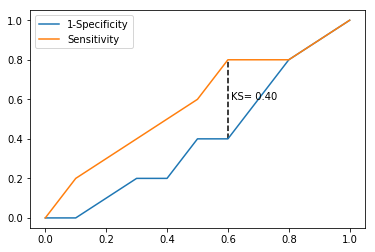

In [59]:
# 导入虚拟数据
virtual_data = pd.read_excel(r'virtual_data.xlsx')
# 应用自定义函数绘制k-s曲线
plot_ks(y_test = virtual_data.Class, 
        y_score = virtual_data.Score,
        positive_flag = 'P')    

# Logistic回归分类模型的应用
数据：手机设备手机的用户运动数据为例，判断用户所处的运动状态，是步行还是跑步。
一共包含88588条记录，6个与运动相关的自变量，其中三个与运动的加速度有关，另三个与运动方向有关。

## 模型的构建

In [48]:
# 导入第三方模块
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import model_selection

In [49]:
# 读取数据
sports = pd.read_csv(r'Run or Walk.csv')
sports.head()

,date,time,username,activity,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z
0,2017/6/30,13:51:15:847724020,viktor,0,0.2650,-0.7814,-0.0076,-0.0590,0.0325,-2.9296
1,2017/6/30,13:51:16:246945023,viktor,0,0.6722,-1.1233,-0.2344,-0.1757,0.0208,0.1269
2,2017/6/30,13:51:16:446233987,viktor,0,0.4399,-1.4817,0.0722,-0.9105,0.1063,-2.4367
3,2017/6/30,13:51:16:646117985,viktor,0,0.3031,-0.8125,0.0888,0.1199,-0.4099,-2.9336
4,2017/6/30,13:51:16:846738994,viktor,0,0.4814,-0.9312,0.0359,0.0527,0.4379,2.4922


In [50]:
# 提取出所有自变量名称
predictors = sports.columns[4:]
# 构建自变量矩阵
X = sports.ix[:,predictors]
# 提取y变量值
y = sports.activity
# 将数据集拆分为训练集和测试集
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, 
                                                                    y, 
                                                                    test_size = 0.25, 
                                                                    random_state = 1234)

# 利用训练集建模
sklearn_logistic = linear_model.LogisticRegression()
sklearn_logistic.fit(X_train, y_train)
# 返回模型的各个参数
print(sklearn_logistic.intercept_, sklearn_logistic.coef_)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

[4.35613952] [[ 0.48533325  6.86221041 -2.44611637 -0.01344578 -0.1607943   0.13360777]]


第一个数值是截距项，后面6个数值是各自变量的系数值。

In [51]:
# 解释模型回归系数的解释
# 发生比率，表示当其他因素不变的情况下，x轴方向的加速度每增加一个单位，回事跑步发生比变化1.62倍。
np.exp(0.49)   # 发生比率
np.exp(6.86)

1.632316219955379

953.3670674911841

## 模型的预测

In [52]:
# 模型预测
sklearn_predict = sklearn_logistic.predict(X_test)
sklearn_predict
# 预测结果统计
pd.Series(sklearn_predict).value_counts()

array([1, 0, 0, ..., 0, 0, 1], dtype=int64)

0    12121
1    10026
dtype: int64

判断步行状态的样本有12121个，跑步的状态有10026个，单看这两个数据无法判断预测的好坏，需要进行模型评估。

## 模型的评估
混淆矩阵、roc曲线、ks曲线

### 混淆矩阵

In [68]:
# 导入第三方模块
from sklearn import metrics

# 混淆矩阵
# 行，实际的运动状态
# 列，模型预测的运动状态
cm = metrics.confusion_matrix(y_test, sklearn_predict, labels = [0,1])
cm

array([[9971, 1120],
       [2150, 8906]], dtype=int64)

In [54]:
Accuracy = metrics.scorer.accuracy_score(y_test, sklearn_predict)
Sensitivity = metrics.scorer.recall_score(y_test, sklearn_predict)
Specificity = metrics.scorer.recall_score(y_test, sklearn_predict, pos_label=0)
print('模型准确率为%.2f%%:' %(Accuracy*100))
print('正例覆盖率（查全率）为%.2f%%' %(Sensitivity*100))
print('负例覆盖率为%.2f%%' %(Specificity*100))

模型准确率为85.24%:
正例覆盖率（查全率）为80.55%
负例覆盖率为89.90%


模型的整体预测准确率达到85.24%, 正确预测到正例在实际正例中占比超过80%，正确预测到负例在实际负例中占比更是接近90%，说明模型更好的拟合了负例的特性。

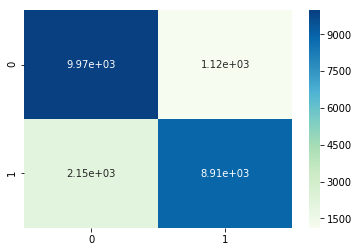

In [55]:
# 混淆矩阵的可视化
# 导入第三方模块
import seaborn as sns
import matplotlib.pyplot as plt
# 绘制热力图
sns.heatmap(cm, annot = True, fmt = '.2e',cmap = 'GnBu')
# 图形显示
plt.show()

### roc曲线

In [56]:
sklearn_logistic.predict_proba(X_test)

array([[0.46048548, 0.53951452],
       [0.94650097, 0.05349903],
       [0.91585343, 0.08414657],
       ...,
       [0.93273396, 0.06726604],
       [0.80920741, 0.19079259],
       [0.05483416, 0.94516584]])

Text(0.5, 0.3, 'ROC curve (area = 0.93)')

Text(0.5, 0, '1-Specificity')

Text(0, 0.5, 'Sensitivity')

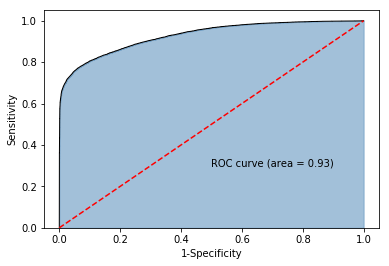

In [57]:
# y得分为模型预测正例的概率
y_score = sklearn_logistic.predict_proba(X_test)[:,1]

# 计算不同阈值下，fpr和tpr的组合值，其中fpr表示1-Specificity，tpr表示Sensitivity
fpr,tpr,threshold = metrics.roc_curve(y_test, y_score)

# 计算AUC的值
roc_auc = metrics.auc(fpr,tpr)

# 绘制面积图
plt.stackplot(fpr, tpr, color='steelblue', alpha = 0.5, edgecolor = 'black')
# 添加边际线
plt.plot(fpr, tpr, color='black', lw = 1)
# 添加对角线
plt.plot([0,1],[0,1], color = 'red', linestyle = '--')
# 添加文本信息
plt.text(0.5,0.3,'ROC curve (area = %0.2f)' % roc_auc)
# 添加x轴与y轴标签
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
# 显示图形
plt.show()

auc面积高达0.93，远高于评估标准0.8，可以认为模型是合理的，较好的刻画了数据特征。

### K-S曲线

In [58]:
y_score

array([0.53951452, 0.05349903, 0.08414657, ..., 0.06726604, 0.19079259,
       0.94516584])

   cuts        y1        y2        ks
0   0.1  0.000000  0.200253  0.200253
1   0.2  0.000811  0.399783  0.398971
2   0.3  0.002525  0.598408  0.595884
3   0.4  0.047336  0.753708  0.706373
4   0.5  0.160040  0.840991  0.680952
5   0.6  0.296457  0.904486  0.608030
6   0.7  0.447931  0.952786  0.504855
7   0.8  0.618069  0.982453  0.364384
8   0.9  0.805608  0.994664  0.189055


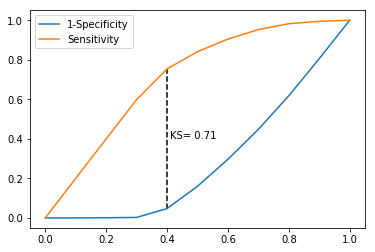

In [61]:
# 调用自定义函数，绘制K-S曲线
plot_ks(y_test = y_test, y_score = pd.Series(y_score), positive_flag = 1)

# 另一种实现logistic回归模型的python工具，即statsmodels

In [15]:
# -----------------------第一步 建模 ----------------------- #
# 导入第三方模块
import statsmodels.api as sm

# 读取数据
sports = pd.read_csv(r'Run or Walk.csv')
# 提取出所有自变量名称
predictors = sports.columns[4:]
# 构建自变量矩阵
X = sports.ix[:,predictors]
# 提取y变量值
y = sports.activity

# 将数据集拆分为训练集和测试集
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, 
                                                                    y, 
                                                                    test_size = 0.25, 
                                                                    random_state = 1234)
# 为训练集和测试集的X矩阵添加常数列1
X_train2 = sm.add_constant(X_train)
X_test2 = sm.add_constant(X_test)
# 拟合Logistic模型
sm_logistic = sm.formula.Logit(y_train, X_train2).fit()
# 返回模型的参数
sm_logistic.params

Optimization terminated successfully.
         Current function value: 0.324875
         Iterations 8


const             4.388537
acceleration_x    0.489617
acceleration_y    6.906590
acceleration_z   -2.459638
gyro_x           -0.014715
gyro_y           -0.161164
gyro_z            0.134655
dtype: float64

In [16]:
# -----------------------第二步 预测构建混淆矩阵 ----------------------- #
# 模型在测试集上的预测
sm_y_probability = sm_logistic.predict(X_test2)  # 返回的是样本被预测为正例的概率值
# 根据概率值，将观测进行分类，以0.5作为阈值
sm_pred_y = np.where(sm_y_probability >= 0.5, 1, 0)
# 混淆矩阵
cm = metrics.confusion_matrix(y_test, sm_pred_y, labels = [0,1])
cm

array([[9967, 1124],
       [2149, 8907]], dtype=int64)

Text(0.5, 0.3, 'ROC curve (area = 0.93)')

Text(0.5, 0, '1-Specificity')

Text(0, 0.5, 'Sensitivity')

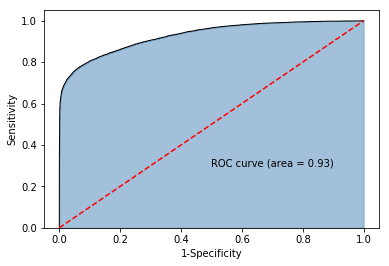

In [17]:
# -----------------------第三步 绘制ROC曲线 ----------------------- #
# 计算真正率和假正率 
fpr,tpr,threshold = metrics.roc_curve(y_test, sm_y_probability)
# 计算auc的值  
roc_auc = metrics.auc(fpr,tpr)
# 绘制面积图
plt.stackplot(fpr, tpr, color='steelblue', alpha = 0.5, edgecolor = 'black')
# 添加边际线
plt.plot(fpr, tpr, color='black', lw = 1)
# 添加对角线
plt.plot([0,1],[0,1], color = 'red', linestyle = '--')
# 添加文本信息
plt.text(0.5,0.3,'ROC curve (area = %0.2f)' % roc_auc)
# 添加x轴与y轴标签
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
# 显示图形
plt.show()

0        0.540706
1        0.052846
2        0.083316
3        0.023588
4        0.999483
5        0.999163
6        0.780273
7        0.052599
8        0.660093
9        0.076744
10       0.213604
11       0.322070
12       0.017269
13       0.540915
14       0.042584
15       0.307959
16       0.072363
17       0.547856
18       0.157903
19       0.075273
20       0.322436
21       0.443753
22       0.994543
23       0.999991
24       0.999965
25       0.804142
26       0.053588
27       0.027503
28       0.310221
29       0.113485
           ...   
22117    0.245841
22118    0.131663
22119    0.424343
22120    0.166108
22121    0.673588
22122    0.031024
22123    0.381876
22124    0.050368
22125    0.074004
22126    0.565206
22127    0.999742
22128    0.999886
22129    0.117050
22130    0.999846
22131    0.999964
22132    0.175933
22133    0.804513
22134    0.748659
22135    0.069335
22136    0.994458
22137    0.028144
22138    0.999153
22139    0.898212
22140    0.639182
22141    0

   cuts        y1        y2        ks
0   0.1  0.000000  0.200253  0.200253
1   0.2  0.000811  0.399783  0.398971
2   0.3  0.002525  0.598408  0.595884
3   0.4  0.047336  0.753708  0.706373
4   0.5  0.160040  0.840991  0.680952
5   0.6  0.296547  0.904396  0.607849
6   0.7  0.447841  0.952876  0.505036
7   0.8  0.618069  0.982453  0.364384
8   0.9  0.805608  0.994664  0.189055


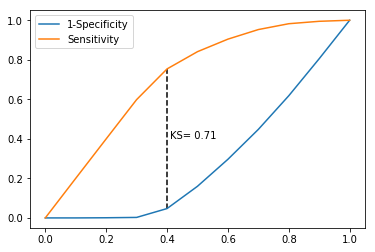

In [19]:
# -----------------------第四步 绘制K-S曲线 ----------------------- #
# 调用自定义函数，绘制K-S曲线
# 重设置索引的目的是plot_ks函数要求两参数是相同的行索引
sm_y_probability.index = np.arange(len(sm_y_probability))    
sm_y_probability
plot_ks(y_test = y_test, y_score = sm_y_probability, positive_flag = 1)